<a href="https://colab.research.google.com/github/Alexander-Klug/sine_model_analysis/blob/main/sine_model_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Runtime 1/10
depth 1
width 100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
depth 2
width 15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
depth 3
width 11
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
depth 4
width 9
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
depth 5
width 8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
depth 6
width 7
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
depth 7
width 6
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
depth 8
width 6
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
depth 9
width 5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
depth 10
width 5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
depth 11
width 5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━

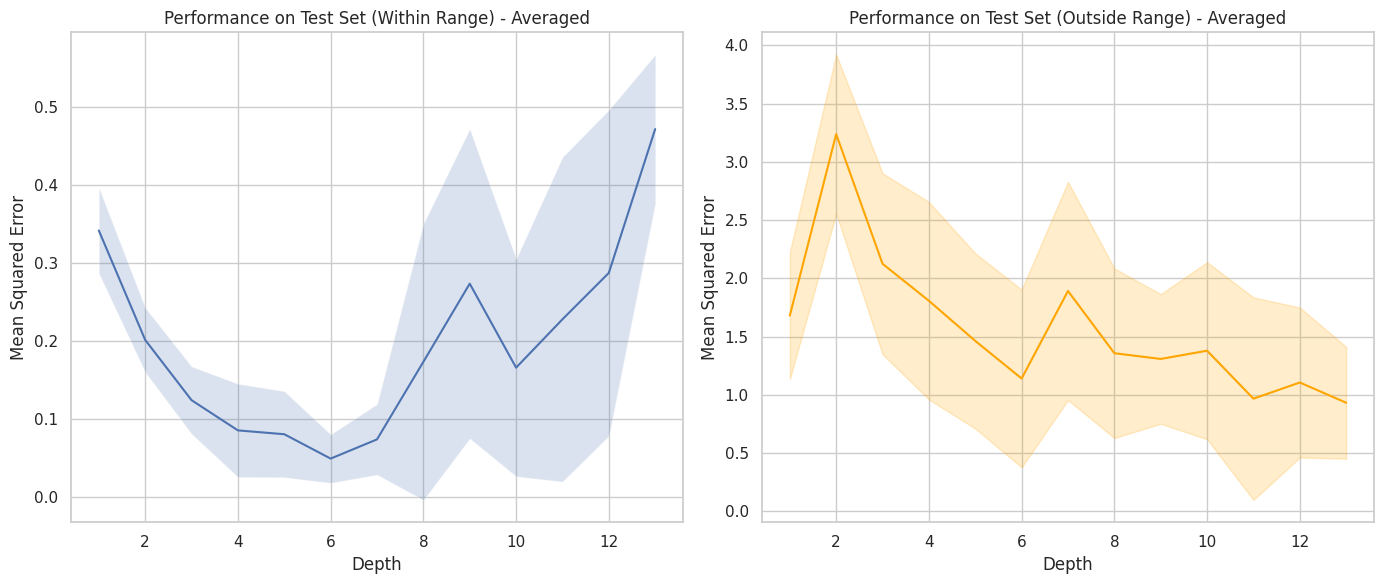

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
import gc
import seaborn as sns


# Step 1: Generate Data
test_range = 10
test_range_outside_multiplier = 1.2
num_samples = 1000
epochs = 100
runtimes = 10  # Number of times to repeat the experiment for averaging

# Generate input data uniformly within the training range
b_values = np.random.uniform(-test_range, test_range, num_samples)
# Calculate target values using the sine function
y_values = np.sin(b_values)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(b_values.reshape(-1, 1), y_values, test_size=0.2, random_state=42)

# Create a larger range and exclude values within the training range for extrapolation testing
b_values_outside = np.random.uniform(-test_range*test_range_outside_multiplier, test_range*test_range_outside_multiplier, num_samples)

# Keep only values that are strictly outside the training range
b_values_outside = b_values_outside[(b_values_outside < -test_range) | (b_values_outside > test_range)]
y_values_outside = np.sin(b_values_outside)

# Define the total number of parameters based on the initial model (1 hidden layer with 100 neurons)
baseline_params = 301  # 1 hidden layer with 100 neurons has 301 parameters

def calculate_width(depth, total_params=baseline_params):
    """
    Calculate the width (number of neurons per layer) for a given depth
    while keeping the total number of trainable parameters approximately constant.
    """
    if depth == 1:
        return 100  # Starting with 100 nodes in the first layer
    else:
        #return int(np.sqrt(total_params / (depth - 1))) #Approximation
        return round((-2-depth+np.sqrt(8+depth**2-4*total_params+4*depth*total_params))/(2*(depth-1)))

# Step 2: Build, Train and Evaluate Models
depths = range(1, 14)  # From 1 to 13 layers

def build_and_evaluate_model(depth, width, X_train, y_train, X_test, y_test, X_outside, y_outside):
    """
    Build a sequential neural network with specified depth and width,
    train it on the training data, and evaluate its performance on the test data.
    """
    model = Sequential()

    # Define the input layer with the correct shape
    model.add(Input(shape=(1,)))

    # Add the first hidden layer
    model.add(Dense(width, activation='relu'))

    # Add subsequent hidden layers
    for _ in range(depth - 1):
        model.add(Dense(width, activation='relu'))

    # Add the output layer
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    #model.summary()

    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    # Evaluate performance on the test set within the training range
    y_pred = model.predict(X_test)
    mse_inside = mean_squared_error(y_test, y_pred)

    # Evaluate performance on the test set outside the training range
    y_pred_outside = model.predict(X_outside)
    mse_outside = mean_squared_error(y_outside, y_pred_outside)

    # Clear the session and delete the model
    K.clear_session()
    del model, y_pred, y_pred_outside  # Explicitly delete the model and predictions
    gc.collect()

    return mse_inside, mse_outside

# Initialize arrays to store the MSE results for each run
mse_inside_runs = np.zeros((runtimes, len(depths)))
mse_outside_runs = np.zeros((runtimes, len(depths)))

# Repeat the experiment multiple times to average out variability
for run in range(runtimes):
    print(f"Runtime {run + 1}/{runtimes}")
    mse_inside_list = []
    mse_outside_list = []

    for depth in depths:
        width = calculate_width(depth)
        print('depth', depth)
        print('width', width)
        mse_inside, mse_outside = build_and_evaluate_model(depth, width, X_train, y_train, X_test, y_test, b_values_outside.reshape(-1, 1), y_values_outside)
        mse_inside_list.append(mse_inside)
        mse_outside_list.append(mse_outside)

    # Store MSE results for each run
    mse_inside_runs[run, :] = mse_inside_list
    mse_outside_runs[run, :] = mse_outside_list

# Calculate the mean and standard deviation across all runs
mse_inside_avg = mse_inside_runs.mean(axis=0)
mse_outside_avg = mse_outside_runs.mean(axis=0)
mse_inside_std = mse_inside_runs.std(axis=0)
mse_outside_std = mse_outside_runs.std(axis=0)

# Step 3: Plot the Results with Error Bars
sns.set(style="whitegrid")  # Set the background to white

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x=depths, y=mse_inside_avg)
plt.fill_between(depths, mse_inside_avg - mse_inside_std, mse_inside_avg + mse_inside_std, alpha=0.2)
plt.title("Performance on Test Set (Within Range) - Averaged")
plt.xlabel("Depth")
plt.ylabel("Mean Squared Error")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(x=depths, y=mse_outside_avg, color='orange')
plt.fill_between(depths, mse_outside_avg - mse_outside_std, mse_outside_avg + mse_outside_std, color='orange', alpha=0.2)
plt.title("Performance on Test Set (Outside Range) - Averaged")
plt.xlabel("Depth")
plt.ylabel("Mean Squared Error")
plt.grid(True)

plt.tight_layout()
plt.show()


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[100, 15, 11, 9, 8, 7, 6, 6, 5, 5, 5, 5, 4]
[301, 286, 298, 298, 313, 302, 271, 313, 256, 286, 316, 346, 253]


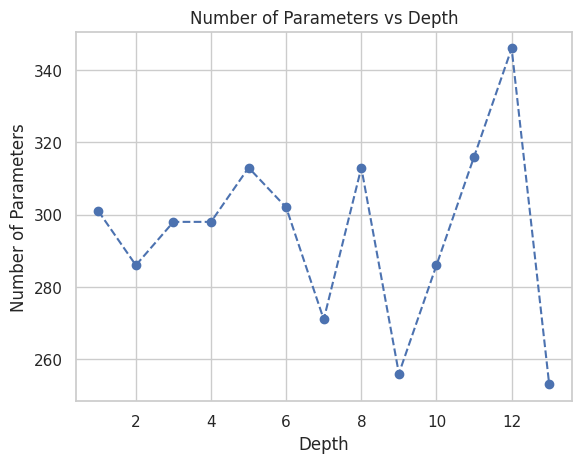

In [ ]:
baseline_params = 301  # 1 hidden layer with 100 neurons has 301 parameters
calculate_width(depth)
depths = range(1, 14)  # From 1 to 13 layers
params = []
widths = []
for depth in depths:
    width = calculate_width(depth)
    widths.append(width)
    params.append((depth-1)*width**2 +(depth+2)*width + 1)
print(list(depths))
print(widths)
print(params)

plt.plot(depths, params,'o', color='C0')
plt.plot(depths, params,'--', color='C0')
plt.xlabel('Depth')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters vs Depth')
plt.grid(True)
plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 7)                   │              14 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302 (1.18 KB)

 Trainable params: 302 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.4759 - val_loss: 0.5231
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4465 - val_loss: 0.5284
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4372 - val_loss: 0.5194
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4312 - val_loss: 0.5195
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4447 - val_loss: 0.5120
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4245 - val_loss: 0.5070
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4062 - val_loss: 0.4907
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3891 - val_loss: 0.4661

<ipython-input-22-017003274445>:94: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


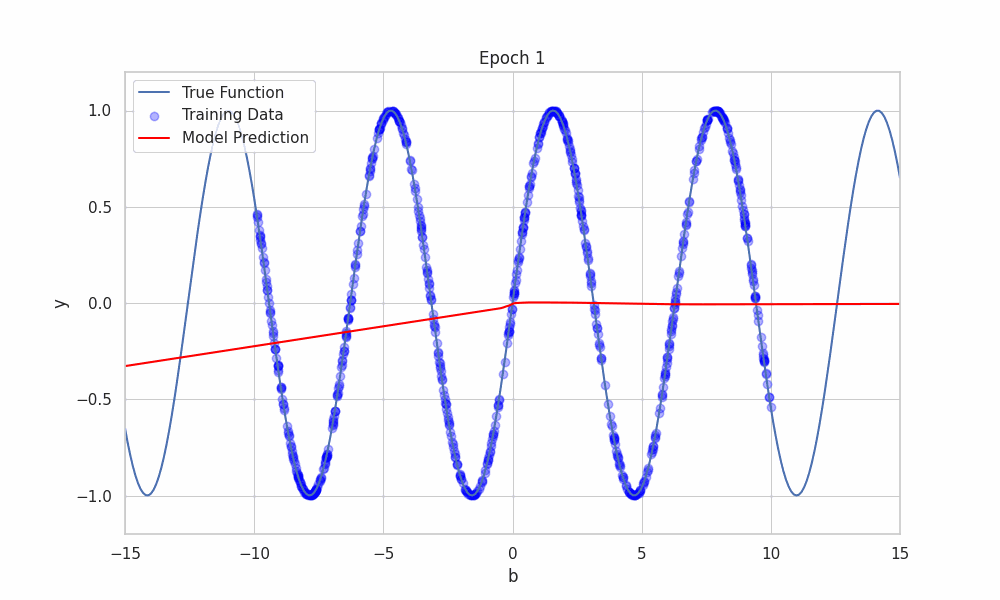

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import imageio
import os


# Generate synthetic data
np.random.seed(42)

test_range = 10
test_range_outside_multiplier = 1.5
n_samples = 1000
epochs = 100
chosen_depth = 6
chosen_width = 7
scaling = 1.0  # Scaling factor for the sine function

# Generate synthetic data for training and testing
b = np.random.uniform(-test_range, test_range, n_samples)  # Input feature
y = scaling*np.sin(b)  # Target with a sine relationship

# Split data into training and testing sets
train_indices = np.random.choice(range(n_samples), size=int(n_samples * 0.8), replace=False)
test_indices = list(set(range(n_samples)) - set(train_indices))

b_train, y_train = b[train_indices], y[train_indices]
b_test, y_test = b[test_indices], y[test_indices]


# Build the model with the chosen parameters
def build_model(input_dim, width, depth):
    """
    Build and compile a sequential neural network model with specified depth and width.
    """
    model = Sequential()
    # Add the first hidden layer
    model.add(Dense(width, input_dim=input_dim, activation='relu'))

    # Add additional hidden layers
    for _ in range(depth - 1):
        model.add(Dense(width, activation='relu'))

    # Add the output layer
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate and summarize the model
model = build_model(input_dim=1, width=chosen_width, depth=chosen_depth)
model.summary()

# Prepare to store predictions for each epoch to create a GIF later
predictions_during_training = []
b_extended = np.linspace(-test_range*test_range_outside_multiplier, test_range*test_range_outside_multiplier, 300)  # Extended range for testing
y_true = scaling*np.sin(b_extended)

# Custom callback to store predictions after each epoch
class PredictionHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(b_extended)
        predictions_during_training.append(y_pred)

# Train the model
history = model.fit(b_train, y_train, epochs=epochs, batch_size=32, validation_data=(b_test, y_test),
                    callbacks=[PredictionHistory()])

# Create GIF

# Create a subfolder to store images
subfolder = 'frames'
os.makedirs(subfolder, exist_ok=True)

images = []
for i, y_pred in enumerate(predictions_during_training):
    plt.figure(figsize=(10, 6))
    plt.plot(b_extended, y_true, label='True Function')
    plt.scatter(b_train, y_train, label='Training Data', color='blue', alpha=0.3)
    plt.plot(b_extended, y_pred, label='Model Prediction', color='red')
    plt.title(f'Epoch {i+1}')
    plt.xlim(-test_range*test_range_outside_multiplier, test_range*test_range_outside_multiplier)
    plt.ylim(-1.2, 1.2)
    plt.legend(loc=2)
    plt.xlabel('b')
    plt.ylabel('y')

    # Save the plot as an image in the subfolder and add it to the list
    image_path = os.path.join(subfolder, f'frame_{i}.png')
    plt.savefig(image_path)
    images.append(imageio.imread(image_path))
    plt.close()

# Save images as GIF
gif_filename = f'training_progress_{chosen_depth}_{chosen_width}.gif'
imageio.mimsave(gif_filename, images, fps=2)  # Adjust fps for speed

# Optionally delete the images after creating the GIF
for image_path in os.listdir(subfolder):
    os.remove(os.path.join(subfolder, image_path))
os.rmdir(subfolder)

# Display the GIF
from IPython.display import Image
Image(filename=gif_filename)